In [1]:
# Ciencia de Datos - TP1
# Grupo 10 - Francisca Cetra, Mariano Ripoll y Justina Rivero Ayerza
# Trabajo Práctico 1: Un primer encuentro con la EPH
# Universidad de San Andrés - 2025

In [21]:
!pip install openpyxl 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
os.getcwd() # Ver donde estamos ubicados

'/Users/franciscacetraorisderoa/Desktop/TP 1 Datos/Datos'

In [22]:
# PARTE I: : Familiarizandonos con la base EPH y limpieza

DATA_DIR = "/Users/franciscacetraorisderoa/Desktop/TP 1 Datos/Datos"  # La dirección que te tira la función getcwd
#Direccion de la carpeta con las bases de datos

print("Intentando cargar archivos desde:", os.path.abspath(DATA_DIR))
print("Archivos en 'Datos':", os.listdir(DATA_DIR))

# Cargar bases con mensajes de estado
print("Cargando 2005 (.dta)...")
df05 = pd.read_stata(f"{DATA_DIR}/usu_individual_T105.dta", convert_categoricals=False)
print("OK 2005:", df05.shape)

print("Cargando 2025 (.xlsx)...")
df25 = pd.read_excel(f"{DATA_DIR}/usu_individual_T125.xlsx")
print("OK 2025:", df25.shape)

#La tabla la carga raro, asi que tenemos que decirle qué usar de head y eliminar los NaN
print("Cargando tabla adulto equivalente (.xlsx)...")
tabla_adulto_equiv_cruda = pd.read_excel(f"{DATA_DIR}/tabla_adulto_equiv.xlsx", header=None)
#identifico la fila donde está "Edad" y la guardo en head
header_edad = tabla_adulto_equiv_cruda[tabla_adulto_equiv_cruda.iloc[:,0]=="Edad"].index[0]
#vuelvo a guardar la tabla, ahora usando el header
tabla_adulto_equiv = pd.read_excel(f"{DATA_DIR}/tabla_adulto_equiv.xlsx", header=header_edad)
#saco los NaN
tabla_adulto_equiv = tabla_adulto_equiv[tabla_adulto_equiv["Edad"].notna()].reset_index(drop=True)
print("OK tabla AE:", tabla_adulto_equiv.shape)


# Mostrar las primeras filas para comprobar que cargaron ok las bases
display(df05.head(3))
display(df25.head(3))
display(tabla_adulto_equiv.head(3))

# Función para estandarizar nombres de las columnas
def estandarizar_columnas(df):
    df = df.copy()
    df.columns = [c.strip().upper().replace(" ", "_") for c in df.columns]
    return df

# Se lo aplicamos a las 3 bases
df05 = estandarizar_columnas(df05)
df25 = estandarizar_columnas(df25)
tabla_adulto_equiv = estandarizar_columnas(tabla_adulto_equiv)

# Hacemos una carpeta donde se van a guardar imagenes con las figuras
CARPETA_FIG = "Figuras"
os.makedirs(CARPETA_FIG, exist_ok=True)
print(f"Las figuras se guardarán en: {CARPETA_FIG}/")

Intentando cargar archivos desde: /Users/franciscacetraorisderoa/Desktop/TP 1 Datos/Datos
Archivos en 'Datos': ['usu_individual_T125.xlsx', '.DS_Store', 'TP1_V_Ejs_completos.ipynb', 'TP1_Grupo10.ipynb', 'tabla_adulto_equiv.xlsx', '.ipynb_checkpoints', 'Figuras', 'usu_individual_T105.dta']
Cargando 2005 (.dta)...
OK 2005: (47030, 176)
Cargando 2025 (.xlsx)...
OK 2025: (45425, 235)
Cargando tabla adulto equivalente (.xlsx)...
OK tabla AE: (29, 3)


,CODUSU,nro_hogar,componente,h15,ano4,trimestre,region,mas_500,aglomerado,pondera,...,deccfr,ideccfr,rdeccfr,gdeccfr,pdeccfr,adeccfr,pj1_1,pj2_1,pj3_1,idimpp
0,125098,1.0,1.0,1.0,2005.0,1.0,1.0,S,32.0,1017.0,...,08,,07,08,,05,0.0,0.0,0.0,00000
1,125188,1.0,1.0,1.0,2005.0,1.0,1.0,S,32.0,1062.0,...,02,,02,02,,01,0.0,0.0,0.0,40020
2,125188,1.0,2.0,1.0,2005.0,1.0,1.0,S,32.0,1062.0,...,02,,02,02,,01,0.0,0.0,0.0,00000


,CODUSU,ANO4,TRIMESTRE,NRO_HOGAR,COMPONENTE,H15,REGION,MAS_500,AGLOMERADO,PONDERA,...,V21_03_M,V22_01_M,V22_02_M,V22_03_M,P_DECCF,P_RDECCF,P_GDECCF,P_PDECCF,P_IDECCF,P_ADECCF
0,TQRMNOVQVHJOLOCDEFKID00875778,2025,1,1,2,1,43,S,4,927,...,0,0,0,0,3.0,2.0,3.0,NaN,3.0,2.0
1,TQRMNOVQVHJOLOCDEFKID00875778,2025,1,1,3,0,43,S,4,927,...,0,0,0,0,3.0,2.0,3.0,NaN,3.0,2.0
2,TQRMNOVQVHJOLOCDEFKID00875778,2025,1,1,4,0,43,S,4,927,...,0,0,0,0,3.0,2.0,3.0,NaN,3.0,2.0


,Edad,Mujeres,Varones
0,Menor de 1 año,0.35,0.35
1,1año,0.37,0.37
2,2 años,0.46,0.46


Las figuras se guardarán en: Figuras/


In [23]:
# Filtramos región GBA y agregar YEAR

# Definición usada: GBA ≡ AGLOMERADO ∈ {32 (CABA), 33 (Partidos GBA)}
# Si no encuentra variable AGLOMERADO, usamos REGION == 1 (normalizado)

def normalizar_region(series):
    # Convierte REGION a string sin ceros a la izquierda: '01' -> '1', 1 -> '1', etc.
    return series.astype(str).str.strip().str.lstrip("0").replace({"": "0"})

def filtrar_gba(df):
    # Devuelve solo filas del Gran Buenos Aires (GBA). Preferimos AGLOMERADO (32,33). Si no existe, tomamos REGION==1.

    df = df.copy()
    if "AGLOMERADO" in df.columns:
        # Convertimos a num para tolerar '32', '32.0', etc.
        ag = pd.to_numeric(df["AGLOMERADO"], errors="coerce")
        return df[ag.isin([32, 33])]
    elif "REGION" in df.columns:
        reg = normalizar_region(df["REGION"])
        return df[reg == "1"]
    else:
        raise ValueError("No encuentro AGLOMERADO ni REGION para filtrar GBA.")

# Aplicar filtro GBA a cada base
df05_gba = filtrar_gba(df05)
df25_gba = filtrar_gba(df25)

# Agregar columna YEAR
df05_gba = df05_gba.copy()
df25_gba = df25_gba.copy()
df05_gba["YEAR"] = 2005
df25_gba["YEAR"] = 2025

In [24]:
# 2 a) 
# Unimos las dos bases ya filtradas por GBA y con YEAR agregado

# 2 a) Unión (versión final)
df_unida = pd.concat([df05_gba, df25_gba], ignore_index=True)

print("Dimensiones base unida:", df_unida.shape)
display(df_unida.head(5))

# ---------------------------------------------------------------------------------------------------------------------------
# Esto lo hacemos porque habíamos tenido errores filtrando, para chequear que tengamos datos de ambos años de esa región

# Cantidad de filas por año
print("Filas por año:")
print(df_unida["YEAR"].value_counts().sort_index())

# Chequeo de AGLOMERADO por año
if "AGLOMERADO" in df_unida.columns:
    print("\nChequeo rápido de AGLOMERADO por año:")
    for y in sorted(df_unida["YEAR"].unique()):
        u = pd.to_numeric(df_unida.loc[df_unida["YEAR"]==y, "AGLOMERADO"], errors="coerce").dropna().unique()
        print(y, sorted(u.tolist()))

df_final= df_unida

Dimensiones base unida: (16665, 244)


,CODUSU,NRO_HOGAR,COMPONENTE,H15,ANO4,TRIMESTRE,REGION,MAS_500,AGLOMERADO,PONDERA,...,V21_03_M,V22_01_M,V22_02_M,V22_03_M,P_DECCF,P_RDECCF,P_GDECCF,P_PDECCF,P_IDECCF,P_ADECCF
0,125098,1.0,1.0,1.0,2005.0,1.0,1.0,S,32.0,1017.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,125188,1.0,1.0,1.0,2005.0,1.0,1.0,S,32.0,1062.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,125188,1.0,2.0,1.0,2005.0,1.0,1.0,S,32.0,1062.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,125188,1.0,3.0,0.0,2005.0,1.0,1.0,S,32.0,1062.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,125242,1.0,1.0,1.0,2005.0,1.0,1.0,S,32.0,1103.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Filas por año:
YEAR
2005    9484
2025    7181
Name: count, dtype: int64

Chequeo rápido de AGLOMERADO por año:
2005 [32.0, 33.0]
2025 [32.0, 33.0]


Dimensiones base final (15 vars + YEAR): (16665, 16)
Variables finales: ['CH04', 'CH06', 'CH07', 'CH08', 'NIVEL_ED', 'ESTADO', 'CAT_INAC', 'IPCF', 'ITF', 'PONDERA', 'CAT_OCUP', 'AGLOMERADO', 'CODUSU', 'NRO_HOGAR', 'PP3E_TOT', 'YEAR']


,CH04,CH06,CH07,CH08,NIVEL_ED,ESTADO,CAT_INAC,IPCF,ITF,PONDERA,CAT_OCUP,AGLOMERADO,CODUSU,NRO_HOGAR,PP3E_TOT,YEAR
0,1.0,80.0,4.0,1.0,3.0,3.0,1.0,583.0,583.0,1017.0,0.0,32.0,125098,1.0,0.0,2005
1,1.0,26.0,2.0,4.0,4.0,1.0,0.0,150.0,450.0,1062.0,2.0,32.0,125188,1.0,20.0,2005
2,2.0,27.0,2.0,4.0,6.0,3.0,4.0,150.0,450.0,1062.0,0.0,32.0,125188,1.0,0.0,2005
3,2.0,-1.0,5.0,4.0,7.0,4.0,5.0,150.0,450.0,1062.0,0.0,32.0,125188,1.0,0.0,2005
4,2.0,71.0,4.0,1.0,2.0,3.0,1.0,855.0,855.0,1103.0,0.0,32.0,125242,1.0,0.0,2005


Dtypes (solo formato, sin limpiar):
CH04           float64
CH06           float64
CH07          category
CH08          category
NIVEL_ED      category
ESTADO        category
CAT_INAC      category
IPCF           float64
ITF            float64
PONDERA        float64
CAT_OCUP      category
AGLOMERADO    category
CODUSU        category
NRO_HOGAR      float64
PP3E_TOT       float64
YEAR             int64
dtype: object

Top 5 faltantes 2005:
CH04        0
CH06        0
CH07        0
CH08        0
NIVEL_ED    0
dtype: int64

Top 5 faltantes 2025:
PP3E_TOT    3783
CH06           0
CH04           0
CH08           0
NIVEL_ED       0
dtype: int64


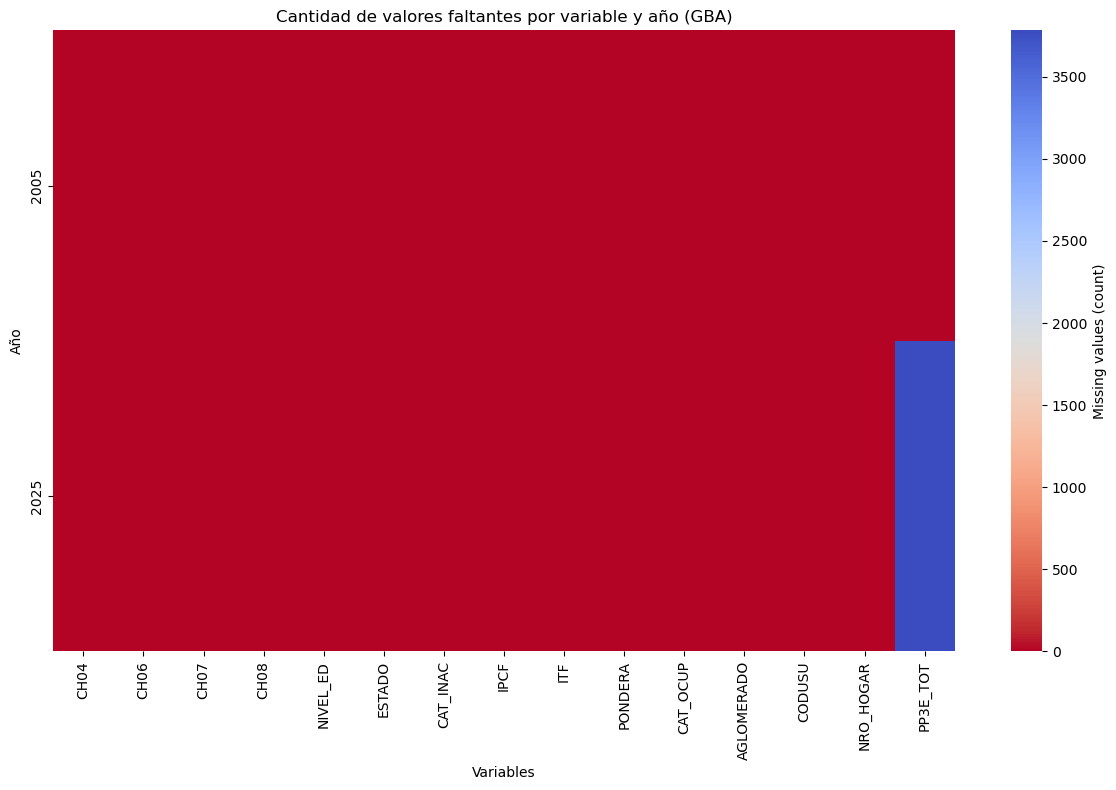

Heatmap guardado en Figuras/heatmap_faltantes.png


In [26]:
# 2. b) Selección y homogeneización de 15 variables (incluyendo las obligatorias),faltantes por año y HEATMAP

# Equivalencias 2005/2025 -> nombre final homogéneo
equivalencias = {
    "CH04": ["CH04", "CH04"],                  # sexo
    "CH06": ["CH06", "CH06"],                  # edad
    "CH07": ["CH07", "CH07"],                  # estado conyugal
    "CH08": ["CH08", "CH08"],                  # cobertura de salud
    "NIVEL_ED": ["NIVEL_ED", "NIVEL_EDUC"],    # nivel educativo (puede cambiar nombre)
    "ESTADO": ["ESTADO", "ESTADO"],            # condición de actividad
    "CAT_INAC": ["CAT_INAC", "CAT_INAC"],      # categoría inactividad
    "IPCF": ["IPCF", "IPCF"],                  # ingreso per cápita familiar
    "ITF": ["ITF", "ITF"],                     # ingreso total familiar
    "PONDERA": ["PONDERA", "PONDERA"],         # factor de expansión
    "CAT_OCUP": ["CAT_OCUP", "CAT_OCUP"],      # categoría ocupacional
    "AGLOMERADO": ["AGLOMERADO", "AGLOMERADO"],
    "CODUSU": ["CODUSU", "CODUSU"],            # identificador de hogar
    "NRO_HOGAR": ["NRO_HOGAR", "NRO_HOGAR"],   # número de hogar
    "PP3E_TOT": ["PP3E_TOT", "PP3E_TOT"]       # horas trabajadas
}

# Creamos columnas homogéneas en la base unida
df_vars = df_unida.copy()
for final, (var05, var25) in equivalencias.items():
    if final not in df_vars.columns:
        if var05 in df_vars.columns:
            df_vars[final] = df_vars[var05]
        elif var25 in df_vars.columns:
            df_vars[final] = df_vars[var25]
        else:
            print(f"No se encontró {final} en ninguna base")

# Nos quedamos con las 15 finales + YEAR
vars_15 = list(equivalencias.keys())
df_final = df_vars[vars_15 + ["YEAR"]].copy()

print("Dimensiones base final (15 vars + YEAR):", df_final.shape)
print("Variables finales:", df_final.columns.tolist())
display(df_final.head())

# Tipificado básico (solo FORMATO, sin limpiar valores)
#    -> así el heatmap de NA refleja la base antes de limpiar (porque la limpieza la hacemos en el c)
vars_numericas = ["CH04","CH06","IPCF","ITF","PONDERA","PP3E_TOT","NRO_HOGAR","YEAR"]
vars_categoricas = ["CH07","CH08","NIVEL_ED","ESTADO","CAT_INAC","CAT_OCUP","AGLOMERADO","CODUSU"]

for v in vars_numericas:
    if v in df_final.columns:
        df_final[v] = pd.to_numeric(df_final[v], errors="coerce")

if "CODUSU" in df_final.columns: #CODUSU es la identifiación del hogar
    df_final["CODUSU"] = df_final["CODUSU"].astype(str)

for v in vars_categoricas:
    if v in df_final.columns:
        df_final[v] = df_final[v].astype("category")

print("Dtypes (solo formato, sin limpiar):")
print(df_final[vars_15 + ["YEAR"]].dtypes)

# Faltantes por año (conteo) y HEATMAP 
miss_2005 = df_final.loc[df_final["YEAR"]==2005, vars_15].isna().sum().sort_values(ascending=False)
miss_2025 = df_final.loc[df_final["YEAR"]==2025, vars_15].isna().sum().sort_values(ascending=False)

print("\nTop 5 faltantes 2005:")
print(miss_2005.head(5))
print("\nTop 5 faltantes 2025:")
print(miss_2025.head(5))

faltantes_tabla = (
    pd.concat([miss_2005.rename(2005), miss_2025.rename(2025)], axis=1)
      .fillna(0).astype(int)
)

# Guardar y mostrar heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(faltantes_tabla.T, annot=False, cmap="coolwarm_r",
            cbar_kws={"label": "Missing values (count)"})
plt.title("Cantidad de valores faltantes por variable y año (GBA)")
plt.xlabel("Variables")
plt.ylabel("Año")
plt.tight_layout()
plt.savefig(f"{CARPETA_FIG}/heatmap_faltantes.png", dpi=150, bbox_inches="tight")
plt.show()
print(f"Heatmap guardado en {CARPETA_FIG}/heatmap_faltantes.png")

In [27]:
# Limpieza
# 2. c) Corrección de valores sin sentido (viendo diccionarios de la EPH)
# ==============================

df_corr = df_final.copy()

# Ingresos
# ITF (Ingreso Total Familiar): hogares con valores negativos -> NaN
if "ITF" in df_corr.columns:
    df_corr.loc[df_corr["ITF"] < 0, "ITF"] = np.nan

# IPCF (Ingreso per cápita familiar): no puede ser negativo -> NaN
if "IPCF" in df_corr.columns:
    df_corr.loc[df_corr["IPCF"] < 0, "IPCF"] = np.nan

# Horas trabajadas
# PP3E_TOT: descartamos valores imposibles (<0 o >120 hs/semana)
if "PP3E_TOT" in df_corr.columns:
    df_corr.loc[(df_corr["PP3E_TOT"] < 0) | (df_corr["PP3E_TOT"] > 120), "PP3E_TOT"] = np.nan

# Edad
# CH06: restringimos a 0–100 años
if "CH06" in df_corr.columns:
    df_corr.loc[(df_corr["CH06"] < 0) | (df_corr["CH06"] > 100), "CH06"] = np.nan

# Sexo
# CH04: válido solo 1=Varón, 2=Mujer
if "CH04" in df_corr.columns:
    df_corr.loc[~df_corr["CH04"].isin([1, 2]), "CH04"] = np.nan

# Categóricas
# Códigos típicos de “no respuesta” (9, 99, 999) -> NaN
for var in ["CH07","CH08","NIVEL_ED","ESTADO","CAT_INAC","CAT_OCUP","AGLOMERADO"]:
    if var in df_corr.columns:
        df_corr.loc[df_corr[var].isin([9, 99, 999]), var] = np.nan

print("Limpieza aplicada (ingresos, horas, edad, sexo, categóricas).")

# Dejamos esta como base limpia para lo que sigue
df_final = df_corr


Limpieza aplicada (ingresos, horas, edad, sexo, categóricas).


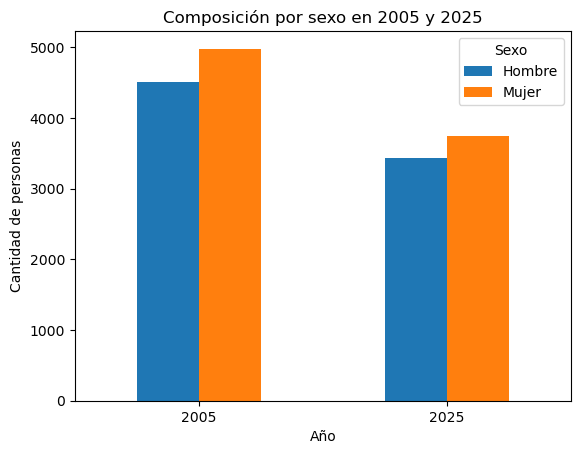

<Figure size 640x480 with 0 Axes>

Gráfico guardado en Figuras/sexo_comparativo_v2.png


In [28]:
# PARTE II: Primer Análisis Exploratorio 

# 3. Gráfico de barras - composición por sexo para 2005 y 2025 (en GBA)
# hacemos solo 1 gráfico de barras comparando ambos años
# ==============================
# Parte II.3 — Composición por sexo (versión prolija final)
# Eje X = Año, barras agrupadas por Sexo
# ==============================

# Agrupar y contar por año y sexo
conteo = df_final.groupby(["YEAR", "CH04"]).size().unstack()

# Crear gráfico de barras
conteo.plot(kind="bar")

# Títulos y etiquetas
plt.title("Composición por sexo en 2005 y 2025")
plt.xlabel("Año")
plt.ylabel("Cantidad de personas")
plt.legend(["Hombre", "Mujer"], title="Sexo")
plt.xticks(rotation=0)

# Mostrar
plt.show()

plt.tight_layout()
plt.savefig(f"{CARPETA_FIG}/sexo_comparativo_v2.png", dpi=150, bbox_inches="tight")
plt.show()

print(f"Gráfico guardado en {CARPETA_FIG}/sexo_comparativo_v2.png")


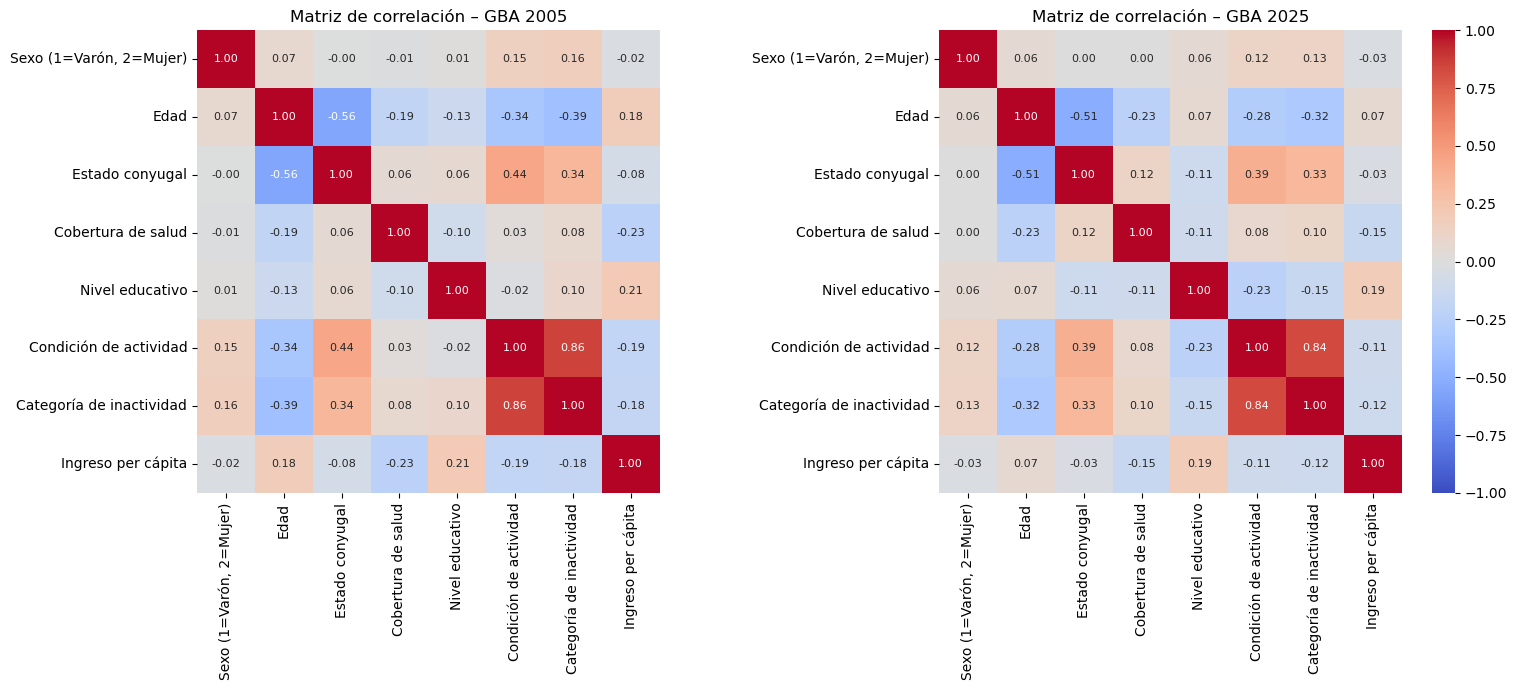

Matriz guardada en Figuras/matriz_correlacion.png


In [29]:
# 4. Matriz de correlación para 2005 y 2025

# Variables que vamos a usar
vars_corr = ["CH04","CH06","CH07","CH08","NIVEL_ED","ESTADO","CAT_INAC","IPCF"]

def preparar_para_corr(df, year):
    """
    Filtra un año y devuelve solo las variables de interés,
    convirtiendo categóricas en códigos numéricos para poder calcular correlaciones.
    """
    # Nos quedamos solo con las variables de la consigna y el año elegido
    sub = df.loc[df["YEAR"]==year, vars_corr].copy()

    # Convertimos categóricas en códigos numéricos
    # (cada categoría recibe un número distinto, ej: soltero=0, casado=1, etc.)
    categoricas = ["CH07","CH08","NIVEL_ED","ESTADO","CAT_INAC"]
    for var in categoricas:
        if var in sub.columns:
            sub[var] = sub[var].cat.codes

    # Renombramos columnas para que el gráfico sea legible
    sub = sub.rename(columns={
        "CH04": "Sexo (1=Varón, 2=Mujer)",
        "CH06": "Edad",
        "CH07": "Estado conyugal",
        "CH08": "Cobertura de salud",
        "NIVEL_ED": "Nivel educativo",
        "ESTADO": "Condición de actividad",
        "CAT_INAC": "Categoría de inactividad",
        "IPCF": "Ingreso per cápita"
    })
    return sub

# Preparamos cada año por separado
df2005_corr = preparar_para_corr(df_final, 2005)
df2025_corr = preparar_para_corr(df_final, 2025)

# Calculamos las matrices de correlación 
corr2005 = df2005_corr.corr()
corr2025 = df2025_corr.corr()

# Dibujamos dos gráficos (uno para cada año)
fig, axes = plt.subplots(1, 2, figsize=(16,7))

# Gráfico para 2005
sns.heatmap(corr2005, vmin=-1, vmax=1, annot=True, cmap="coolwarm", 
            fmt=".2f", cbar=False, ax=axes[0], square=True,
            annot_kws={"size":8})  # anotaciones de chicas para que no se superpongan 
axes[0].set_title("Matriz de correlación – GBA 2005", fontsize=12)

# Gráfico para 2025
sns.heatmap(corr2025, vmin=-1, vmax=1, annot=True, cmap="coolwarm", 
            fmt=".2f", cbar=True, ax=axes[1], square=True,
            annot_kws={"size":8})
axes[1].set_title("Matriz de correlación – GBA 2025", fontsize=12)

# Ajustamos layout y guardamos
plt.tight_layout()
plt.savefig(f"{CARPETA_FIG}/matriz_correlacion.png", dpi=150, bbox_inches="tight")
plt.show()

print(f"Matriz guardada en {CARPETA_FIG}/matriz_correlacion.png")

In [30]:
df_final.head(3)

,CH04,CH06,CH07,CH08,NIVEL_ED,ESTADO,CAT_INAC,IPCF,ITF,PONDERA,CAT_OCUP,AGLOMERADO,CODUSU,NRO_HOGAR,PP3E_TOT,YEAR
0,1.0,80.0,4.0,1.0,3.0,3.0,1.0,583.0,583.0,1017.0,0.0,32.0,125098,1.0,0.0,2005
1,1.0,26.0,2.0,4.0,4.0,1.0,0.0,150.0,450.0,1062.0,2.0,32.0,125188,1.0,20.0,2005
2,2.0,27.0,2.0,4.0,6.0,3.0,4.0,150.0,450.0,1062.0,0.0,32.0,125188,1.0,0.0,2005


In [31]:
# PARTE 3: 
df_final.head(5)

#5.
# Filtrar los que respondieron (ITF ≠ 0), guardamos una COPIA filtrada del df_final
respondieron = df_final[df_final["ITF"] != 0].copy()
#vemos si salió bien
respondieron.head(3)
# Filtrar los que NO respondieron (ITF = 0)
norespondieron = df_final[df_final["ITF"] == 0].copy()
#vemos si salió bien
norespondieron.head(3)

,CH04,CH06,CH07,CH08,NIVEL_ED,ESTADO,CAT_INAC,IPCF,ITF,PONDERA,CAT_OCUP,AGLOMERADO,CODUSU,NRO_HOGAR,PP3E_TOT,YEAR
489,2.0,39.0,3.0,2.0,5.0,2.0,0.0,0.0,0.0,1401.0,2.0,32.0,155508,1.0,0.0,2005
490,1.0,16.0,5.0,2.0,3.0,3.0,3.0,0.0,0.0,1401.0,0.0,32.0,155508,1.0,0.0,2005
491,2.0,14.0,5.0,2.0,3.0,3.0,3.0,0.0,0.0,1401.0,0.0,32.0,155508,1.0,0.0,2005


In [32]:
tabla_adulto_equiv.head(25) #ver que todo ande bien


,EDAD,MUJERES,VARONES
0,Menor de 1 año,0.35,0.35
1,1año,0.37,0.37
2,2 años,0.46,0.46
3,3 años,0.51,0.51
4,4 años,0.55,0.55
5,5 años,0.60,0.60
6,6 años,0.64,0.64
7,7 años,0.66,0.66
8,8 años,0.68,0.68
9,9 años,0.69,0.69


In [33]:
#6. 

# Encontrar el índice de la fila donde EDAD es "más de 75 años"
idx_max = tabla_adulto_equiv[tabla_adulto_equiv['EDAD'] == "más de 75 años"].index[0]

# Tomar solo hasta esa fila inclusive
tabla_adulto_equiv_recortada = tabla_adulto_equiv.loc[:idx_max].copy()

print(tabla_adulto_equiv_recortada)

              EDAD  MUJERES  VARONES
0   Menor de 1 año     0.35     0.35
1             1año     0.37     0.37
2           2 años     0.46     0.46
3           3 años     0.51     0.51
4           4 años     0.55     0.55
5           5 años     0.60     0.60
6           6 años     0.64     0.64
7           7 años     0.66     0.66
8           8 años     0.68     0.68
9           9 años     0.69     0.69
10         10 años     0.70     0.79
11         11 años     0.72     0.82
12         12 años     0.74     0.85
13         13 años     0.76     0.90
14         14 años     0.76     0.96
15         15 años     0.77     1.00
16         16 años     0.77     1.03
17         17 años     0.77     1.04
18    18 a 29 años     0.76     1.02
19    30 a 45 años     0.77     1.00
20    46 a 60 años     0.76     1.00
21    61 a 75 años     0.67     0.83
22  más de 75 años     0.63     0.74


In [34]:
#Quiero que en EDAD solo queden numeros y que quede una fila por cada edad de 0-100
def expand_edad(row):
    edad_str = row['EDAD'].replace("años", "").replace("año", "").strip()
    
    # "<1 año"
    if edad_str.startswith("Menor de"):
        return [0]
    
    # ">75 años"
    elif edad_str.startswith("más de"):
        return list(range(75, 101))  # de 75 a 100
    
    # Rango "18 a 29"
    elif "a" in edad_str:
        partes = edad_str.split("a")
        start = int(partes[0].strip())
        end = int(partes[1].strip())
        return list(range(start, end + 1))
    
    # Edad única "2"
    else:
        return [int(edad_str.strip())]

# Repetir filas según cantidad de edades en cada rango
tabla_expanded = tabla_adulto_equiv_recortada.loc[
    tabla_adulto_equiv_recortada.index.repeat(
        tabla_adulto_equiv_recortada.apply(lambda row: len(expand_edad(row)), axis=1)
    )
].copy()

# Expandir la columna EDAD para tener una fila por año de edad del 0 al 100
tabla_expanded['EDAD'] = [
    edad
    for idx, row in tabla_adulto_equiv_recortada.iterrows()
    for edad in expand_edad(row)
]

# Convertir a int
tabla_expanded['EDAD'] = tabla_expanded['EDAD'].astype(int)

print(tabla_expanded)
tabla_expanded.head(20)


    EDAD  MUJERES  VARONES
0      0     0.35     0.35
1      1     0.37     0.37
2      2     0.46     0.46
3      3     0.51     0.51
4      4     0.55     0.55
..   ...      ...      ...
22    96     0.63     0.74
22    97     0.63     0.74
22    98     0.63     0.74
22    99     0.63     0.74
22   100     0.63     0.74

[102 rows x 3 columns]


,EDAD,MUJERES,VARONES
0,0,0.35,0.35
1,1,0.37,0.37
2,2,0.46,0.46
3,3,0.51,0.51
4,4,0.55,0.55
5,5,0.60,0.60
6,6,0.64,0.64
7,7,0.66,0.66
8,8,0.68,0.68
9,9,0.69,0.69


In [35]:

# Primero, renombramos columnas para simplificar
df_personas = df_final.copy()
df_personas['EDAD'] = df_personas['CH06'].astype(float)

print(tabla_expanded.columns)
#renombro columnas para q sea mas claro
#hago merge x EDAD
tabla_consumo = tabla_expanded.rename(columns={'MUJERES':'consumo_mujer','VARONES':'consumo_varon'})
df_merge = df_personas.merge(tabla_consumo[['EDAD','consumo_mujer','consumo_varon']], 
                             on='EDAD', how='left')
# Creamos la columna adulto_equiv seleccionando el consumo según sexo
# CH04 == 1 → varón, CH04 == 2 → mujer

#Agrego al df la columna adulto_equiv
df_merge['adulto_equiv'] = np.where(df_merge['CH04'] == 1,
                                    df_merge['consumo_varon'],
                                    df_merge['consumo_mujer'])

Index(['EDAD', 'MUJERES', 'VARONES'], dtype='object')


In [36]:
df_merge.head(10) #chequeo que este bien
#ya se que quedaron CH06 Y EDAD, después lo saco

,CH04,CH06,CH07,CH08,NIVEL_ED,ESTADO,CAT_INAC,IPCF,ITF,PONDERA,CAT_OCUP,AGLOMERADO,CODUSU,NRO_HOGAR,PP3E_TOT,YEAR,EDAD,consumo_mujer,consumo_varon,adulto_equiv
0,1.0,80.0,4.0,1.0,3.0,3.0,1.0,583.0,583.0,1017.0,0.0,32.0,125098,1.0,0.0,2005,80.0,0.63,0.74,0.74
1,1.0,26.0,2.0,4.0,4.0,1.0,0.0,150.0,450.0,1062.0,2.0,32.0,125188,1.0,20.0,2005,26.0,0.76,1.02,1.02
2,2.0,27.0,2.0,4.0,6.0,3.0,4.0,150.0,450.0,1062.0,0.0,32.0,125188,1.0,0.0,2005,27.0,0.76,1.02,0.76
3,2.0,NaN,5.0,4.0,7.0,4.0,5.0,150.0,450.0,1062.0,0.0,32.0,125188,1.0,0.0,2005,NaN,NaN,NaN,NaN
4,2.0,71.0,4.0,1.0,2.0,3.0,1.0,855.0,855.0,1103.0,0.0,32.0,125242,1.0,0.0,2005,71.0,0.67,0.83,0.67
5,1.0,54.0,2.0,1.0,4.0,1.0,0.0,1016.0,5080.0,965.0,2.0,32.0,125436,1.0,40.0,2005,54.0,0.76,1.00,1.00
6,2.0,54.0,2.0,1.0,4.0,3.0,4.0,1016.0,5080.0,965.0,0.0,32.0,125436,1.0,0.0,2005,54.0,0.76,1.00,0.76
7,2.0,27.0,5.0,1.0,4.0,3.0,7.0,1016.0,5080.0,965.0,0.0,32.0,125436,1.0,0.0,2005,27.0,0.76,1.02,0.76
8,1.0,20.0,5.0,1.0,3.0,2.0,0.0,1016.0,5080.0,965.0,3.0,32.0,125436,1.0,0.0,2005,20.0,0.76,1.02,1.02
9,2.0,18.0,5.0,1.0,5.0,3.0,3.0,1016.0,5080.0,965.0,0.0,32.0,125436,1.0,0.0,2005,18.0,0.76,1.02,0.76


In [37]:
#elimino las columnas consumo_varon/mujer
df_final_con_equiv = df_merge.drop(columns=['consumo_varon','consumo_mujer','key_0'], errors='ignore')

df_final_con_equiv.head(10) #chequear que está bien

,CH04,CH06,CH07,CH08,NIVEL_ED,ESTADO,CAT_INAC,IPCF,ITF,PONDERA,CAT_OCUP,AGLOMERADO,CODUSU,NRO_HOGAR,PP3E_TOT,YEAR,EDAD,adulto_equiv
0,1.0,80.0,4.0,1.0,3.0,3.0,1.0,583.0,583.0,1017.0,0.0,32.0,125098,1.0,0.0,2005,80.0,0.74
1,1.0,26.0,2.0,4.0,4.0,1.0,0.0,150.0,450.0,1062.0,2.0,32.0,125188,1.0,20.0,2005,26.0,1.02
2,2.0,27.0,2.0,4.0,6.0,3.0,4.0,150.0,450.0,1062.0,0.0,32.0,125188,1.0,0.0,2005,27.0,0.76
3,2.0,NaN,5.0,4.0,7.0,4.0,5.0,150.0,450.0,1062.0,0.0,32.0,125188,1.0,0.0,2005,NaN,NaN
4,2.0,71.0,4.0,1.0,2.0,3.0,1.0,855.0,855.0,1103.0,0.0,32.0,125242,1.0,0.0,2005,71.0,0.67
5,1.0,54.0,2.0,1.0,4.0,1.0,0.0,1016.0,5080.0,965.0,2.0,32.0,125436,1.0,40.0,2005,54.0,1.00
6,2.0,54.0,2.0,1.0,4.0,3.0,4.0,1016.0,5080.0,965.0,0.0,32.0,125436,1.0,0.0,2005,54.0,0.76
7,2.0,27.0,5.0,1.0,4.0,3.0,7.0,1016.0,5080.0,965.0,0.0,32.0,125436,1.0,0.0,2005,27.0,0.76
8,1.0,20.0,5.0,1.0,3.0,2.0,0.0,1016.0,5080.0,965.0,3.0,32.0,125436,1.0,0.0,2005,20.0,1.02
9,2.0,18.0,5.0,1.0,5.0,3.0,3.0,1016.0,5080.0,965.0,0.0,32.0,125436,1.0,0.0,2005,18.0,0.76


In [38]:
#al df entero le agrego una columna y le asigno el valor de sumar los valores de adulto_equiv agrupado por codusu.
#el observe=False es para evitar el future warning de modificar la base original
df_final_con_equiv['ad_equiv_hogar'] = df_final_con_equiv.groupby('CODUSU', observed=False)['adulto_equiv'].transform('sum').copy()

#Me agrega "ad_equiv_hogar_x	ad_equiv_hogar_y" y no las quiero asi que las elimino
df_final_con_equiv = df_final_con_equiv.drop(columns=['ad_equiv_hogar_x','ad_equiv_hogar_y'], errors='ignore')

#chequeo que esté
df_final_con_equiv.head(10)
#está!! :) 

,CH04,CH06,CH07,CH08,NIVEL_ED,ESTADO,CAT_INAC,IPCF,ITF,PONDERA,CAT_OCUP,AGLOMERADO,CODUSU,NRO_HOGAR,PP3E_TOT,YEAR,EDAD,adulto_equiv,ad_equiv_hogar
0,1.0,80.0,4.0,1.0,3.0,3.0,1.0,583.0,583.0,1017.0,0.0,32.0,125098,1.0,0.0,2005,80.0,0.74,0.74
1,1.0,26.0,2.0,4.0,4.0,1.0,0.0,150.0,450.0,1062.0,2.0,32.0,125188,1.0,20.0,2005,26.0,1.02,1.78
2,2.0,27.0,2.0,4.0,6.0,3.0,4.0,150.0,450.0,1062.0,0.0,32.0,125188,1.0,0.0,2005,27.0,0.76,1.78
3,2.0,NaN,5.0,4.0,7.0,4.0,5.0,150.0,450.0,1062.0,0.0,32.0,125188,1.0,0.0,2005,NaN,NaN,1.78
4,2.0,71.0,4.0,1.0,2.0,3.0,1.0,855.0,855.0,1103.0,0.0,32.0,125242,1.0,0.0,2005,71.0,0.67,0.67
5,1.0,54.0,2.0,1.0,4.0,1.0,0.0,1016.0,5080.0,965.0,2.0,32.0,125436,1.0,40.0,2005,54.0,1.00,4.30
6,2.0,54.0,2.0,1.0,4.0,3.0,4.0,1016.0,5080.0,965.0,0.0,32.0,125436,1.0,0.0,2005,54.0,0.76,4.30
7,2.0,27.0,5.0,1.0,4.0,3.0,7.0,1016.0,5080.0,965.0,0.0,32.0,125436,1.0,0.0,2005,27.0,0.76,4.30
8,1.0,20.0,5.0,1.0,3.0,2.0,0.0,1016.0,5080.0,965.0,3.0,32.0,125436,1.0,0.0,2005,20.0,1.02,4.30
9,2.0,18.0,5.0,1.0,5.0,3.0,3.0,1016.0,5080.0,965.0,0.0,32.0,125436,1.0,0.0,2005,18.0,0.76,4.30


In [39]:
#le cambio el nombre para trabajar más comodos

df_final = df_final_con_equiv

In [40]:
print(df_final['YEAR'].dtype)
print(df_final["ad_equiv_hogar"].dtype)
df_final.head(5)

int64
float64


,CH04,CH06,CH07,CH08,NIVEL_ED,ESTADO,CAT_INAC,IPCF,ITF,PONDERA,CAT_OCUP,AGLOMERADO,CODUSU,NRO_HOGAR,PP3E_TOT,YEAR,EDAD,adulto_equiv,ad_equiv_hogar
0,1.0,80.0,4.0,1.0,3.0,3.0,1.0,583.0,583.0,1017.0,0.0,32.0,125098,1.0,0.0,2005,80.0,0.74,0.74
1,1.0,26.0,2.0,4.0,4.0,1.0,0.0,150.0,450.0,1062.0,2.0,32.0,125188,1.0,20.0,2005,26.0,1.02,1.78
2,2.0,27.0,2.0,4.0,6.0,3.0,4.0,150.0,450.0,1062.0,0.0,32.0,125188,1.0,0.0,2005,27.0,0.76,1.78
3,2.0,NaN,5.0,4.0,7.0,4.0,5.0,150.0,450.0,1062.0,0.0,32.0,125188,1.0,0.0,2005,NaN,NaN,1.78
4,2.0,71.0,4.0,1.0,2.0,3.0,1.0,855.0,855.0,1103.0,0.0,32.0,125242,1.0,0.0,2005,71.0,0.67,0.67


In [41]:
coinciden = df_final['CODUSU'].isin(respondieron['CODUSU'])
print("Cantidad de personas que respondieron:", coinciden.sum())
print("Cantidad de personas que NO respondieron:", (~coinciden).sum())

Cantidad de personas que respondieron: 13776
Cantidad de personas que NO respondieron: 3002


In [42]:
#7. usando base "respondieron" y la nueva df_final con ad_equiv

#vuelvo a hacer una base llamada respondieron pero con la utlima versión del df_final
respondieron = df_final[df_final["ITF"] != 0].copy()
respondieron.head(10)

#var booleana que da True si se cumplen las condiciones:
# 1. el hogar (CODUSU) está en respondieron y coincide con el de df_final
# 2. el año es 2025
mask_2025 = (df_final['CODUSU'].isin(respondieron['CODUSU'])) & (df_final['YEAR'] == 2025)
#var booleana que da True si se cumplen las condiciones:
# 1. el hogar (CODUSU) está en respondieron y coincide con el de df_final
# 2. el año es 2005
mask_2005 = (df_final['CODUSU'].isin(respondieron['CODUSU'])) & (df_final['YEAR'] == 2005)

# selecciona los datos donde mask_año es True y crea la columna ingreso_necesario
# le asigna el valor de ad_equiv_hogar multiplicado, solo cuando mask_año es True
df_final.loc[mask_2025, 'ingreso_necesario'] = df_final.loc[mask_2025, 'ad_equiv_hogar'] * 365177.00
df_final.loc[mask_2005, 'ingreso_necesario'] = df_final.loc[mask_2005, 'ad_equiv_hogar'] * 205.07

#Había que agregarla a respondieron:
respondieron.loc[mask_2025, 'ingreso_necesario'] = respondieron.loc[mask_2025, 'ad_equiv_hogar'] * 365177.00
respondieron.loc[mask_2005, 'ingreso_necesario'] = respondieron.loc[mask_2005, 'ad_equiv_hogar'] * 205.07

respondieron.head(-5)

,CH04,CH06,CH07,CH08,NIVEL_ED,ESTADO,CAT_INAC,IPCF,ITF,PONDERA,CAT_OCUP,AGLOMERADO,CODUSU,NRO_HOGAR,PP3E_TOT,YEAR,EDAD,adulto_equiv,ad_equiv_hogar,ingreso_necesario
0,1.0,80.0,4.0,1.0,3.0,3.0,1.0,583.0,583.0,1017.0,0.0,32.0,125098,1.0,0.0,2005,80.0,0.74,0.74,1.517518e+02
1,1.0,26.0,2.0,4.0,4.0,1.0,0.0,150.0,450.0,1062.0,2.0,32.0,125188,1.0,20.0,2005,26.0,1.02,1.78,3.650246e+02
2,2.0,27.0,2.0,4.0,6.0,3.0,4.0,150.0,450.0,1062.0,0.0,32.0,125188,1.0,0.0,2005,27.0,0.76,1.78,3.650246e+02
3,2.0,NaN,5.0,4.0,7.0,4.0,5.0,150.0,450.0,1062.0,0.0,32.0,125188,1.0,0.0,2005,NaN,NaN,1.78,3.650246e+02
4,2.0,71.0,4.0,1.0,2.0,3.0,1.0,855.0,855.0,1103.0,0.0,32.0,125242,1.0,0.0,2005,71.0,0.67,0.67,1.373969e+02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16755,1.0,12.0,5.0,4.0,3.0,3.0,3.0,50000.0,200000.0,4847.0,0.0,33.0,TQRMNOUUWHLMLMCDEIJAH00882462,1.0,NaN,2025,12.0,0.85,3.13,1.143004e+06
16762,2.0,40.0,5.0,1.0,4.0,1.0,0.0,457000.0,914000.0,2257.0,3.0,33.0,TQRMNOPWYHLMPUCDEIJAH00855321,1.0,32.0,2025,40.0,0.77,1.46,5.331584e+05
16763,1.0,9.0,5.0,1.0,1.0,4.0,3.0,457000.0,914000.0,2257.0,0.0,33.0,TQRMNOPWYHLMPUCDEIJAH00855321,1.0,NaN,2025,9.0,0.69,1.46,5.331584e+05
16764,2.0,45.0,1.0,4.0,6.0,1.0,0.0,266000.0,1064000.0,2514.0,3.0,33.0,TQRMNOUSSHMKPRCDEIJAH00882495,1.0,18.0,2025,45.0,0.77,3.20,1.168566e+06


In [43]:
#esta var booleana va a ser True si el ITF es menor al ingreso necesario y el año es 2025
pobre25 = (respondieron["ITF"]< respondieron["ingreso_necesario"]) & (respondieron["YEAR"]==2025)
pobre25=pobre25.astype(int)
#.astype(int) es para que sea 1 si es True y 0 si es False

#IDEM 2005
pobre05 = (respondieron["ITF"]< respondieron["ingreso_necesario"]) & (respondieron["YEAR"]==2005)
pobre05=pobre05.astype(int)

#a los datos que en respondieron tienen YEAR=2025, les asigno el valor de pobre25 en una nueva columna llamada pobre
respondieron.loc[respondieron['YEAR'] == 2025, 'pobre'] = pobre25[respondieron['YEAR'] == 2025]

respondieron.loc[respondieron['YEAR'] == 2005, 'pobre'] = pobre05[respondieron['YEAR'] == 2005]


In [44]:
# Cantidad de pobres por año
pobres_por_año = respondieron.groupby('YEAR')['pobre'].sum()

# Total de personas por año
total_por_año = respondieron.groupby('YEAR')['pobre'].count()

# Porcentaje de pobres por año
porcentaje_pobres = (pobres_por_año / total_por_año) * 100

#ahí un print para que diga los resultados :)
for YEAR in pobres_por_año.index:
    print(f"La cantidad de pobres en {YEAR} es: {pobres_por_año[YEAR]}")
    print(f"El total de personas en {YEAR} es: {total_por_año[YEAR]}")
    print(f"El porcentaje de pobres en {YEAR} es: {porcentaje_pobres[YEAR]:.2f}%\n")

print("Este n tan diferente en 2005 y 2025 debe tener que ver con la limpieza de datos, pero se ve un aumento en la proporción de pobres entre 2005 y 2025.")

La cantidad de pobres en 2005 es: 2505.0
El total de personas en 2005 es: 9429
El porcentaje de pobres en 2005 es: 26.57%

La cantidad de pobres en 2025 es: 1369.0
El total de personas en 2025 es: 4346
El porcentaje de pobres en 2025 es: 31.50%

Este n tan diferente en 2005 y 2025 debe tener que ver con la limpieza de datos, pero se ve un aumento en la proporción de pobres entre 2005 y 2025.


In [45]:
#9. Tabla estad. descriptivas
tabla_stats = respondieron.groupby("YEAR").agg(
    n = ("pobre", "count"),
    pobres = ("pobre", "sum"),
    porcentaje_pobres = ("pobre", "sum"),  # equivale al % de pobres
    media = ("pobre", "mean"),
    std = ("pobre", "std")
).reset_index()

print(tabla_stats)

   YEAR     n  pobres  porcentaje_pobres     media       std
0  2005  9429  2505.0             2505.0  0.265670  0.441713
1  2025  4346  1369.0             1369.0  0.315002  0.464570


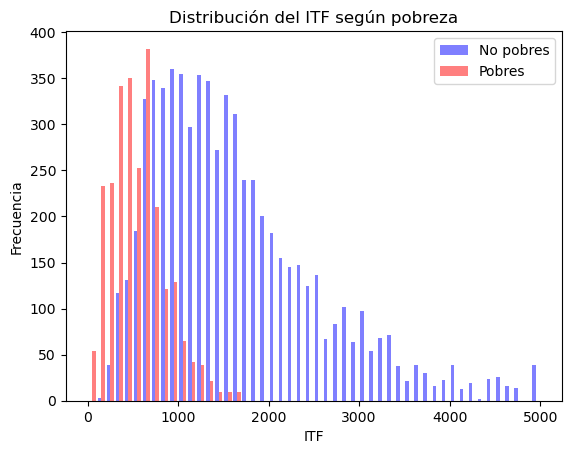

In [46]:
#pruebo Histograma frecuencia de pobres según nivel de ITF de pobres y no pobres
plt.hist([respondieron.loc[respondieron["pobre"]==0, "ITF"],
          respondieron.loc[respondieron["pobre"]==1, "ITF"]],
         bins=50, range=(0,5000), label=["No pobres","Pobres"],
         color=["blue","red"], alpha=0.5)

plt.xlabel("ITF")
plt.ylabel("Frecuencia")
plt.title("Distribución del ITF según pobreza")
plt.legend()
plt.savefig(f"{CARPETA_FIG}/histogramaITF.png", dpi=150, bbox_inches="tight")
plt.show()


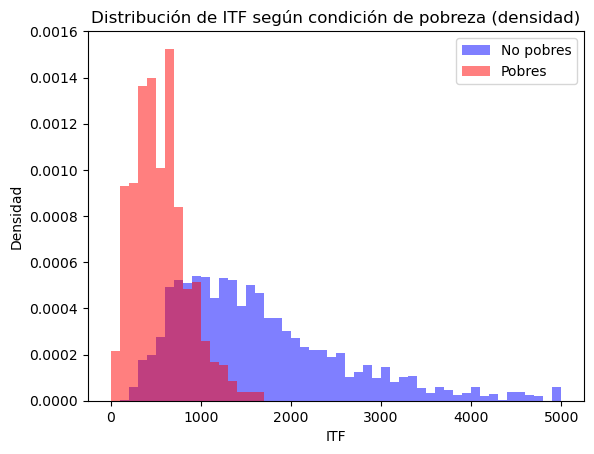

Acá ya se ve la forma que va a tener el Kernel verdadero y se parece bastante al histograma


In [47]:
#tratando de hacer un Kernels de este histograma
itf_no_pobres = respondieron.loc[respondieron["pobre"]==0, "ITF"]
itf_pobres    = respondieron.loc[respondieron["pobre"]==1, "ITF"]

# graficamos histogramas normalizados (por densidad de)
plt.hist(itf_no_pobres, bins=50, range=(0,5000), density=True, 
         color="blue", alpha=0.5, label="No pobres")
plt.hist(itf_pobres, bins=50, range=(0,5000), density=True, 
         color="red", alpha=0.5, label="Pobres")

plt.xlabel("ITF")
plt.ylabel("Densidad")
plt.title("Distribución de ITF según condición de pobreza (densidad)")
plt.legend()
plt.savefig(f"{CARPETA_FIG}/DensidadITF.png", dpi=150, bbox_inches="tight")
plt.show()
print("Acá ya se ve la forma que va a tener el Kernel verdadero y se parece bastante al histograma")


In [48]:
#Intentando KERNELS!!! con código de la tutorial
import sys
!{sys.executable} -m pip install scikit-learn

In [49]:
import sys
#!{sys.executable} -m pip install scipy
#!{sys.executable} -m pip install base
#!pip install -U scikit-learn # update del paquete sklearn/scikit-learn
!{sys.executable} -m pip install --upgrade pandas
!{sys.executable} -m pip install --upgrade numpy
from sklearn.neighbors import KernelDensity

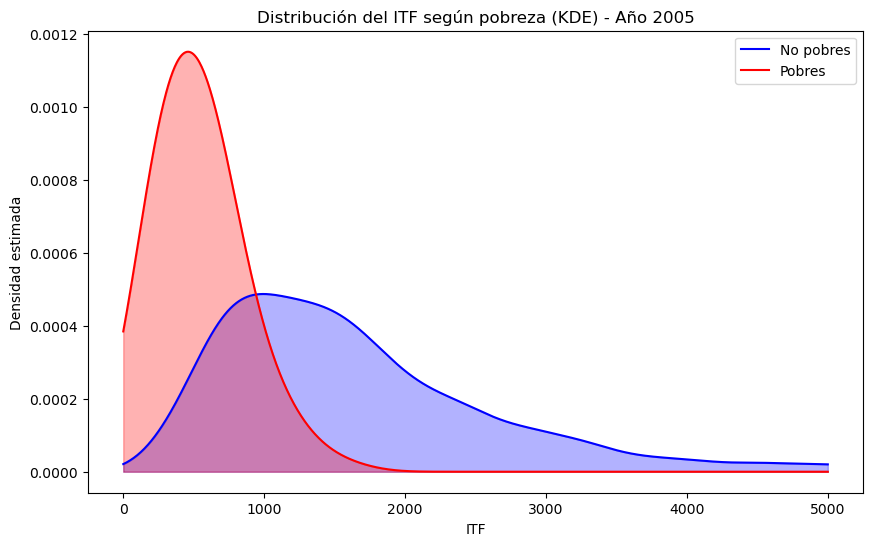

Se ve como la mayoría de las personas pobres tiene un ingreso total familiar bastante bajo, de entre 500 y 600, mientras los no pobres están más esparcidos entre 1000 y 1500.
Por la forma de la curva de no pobres y la superposición con la otra, también se ve que hay personas que no son consideradas pobres, quizás por que son personas que consumen poco, pero sus ingresos son muy bajos.


In [50]:
# Filtro solo año 2005
df2005 = respondieron[respondieron["YEAR"] == 2005]

# Definir colores y etiquetas
colors = {0: "blue", 1: "red"}
labels = {0: "No pobres", 1: "Pobres"}

plt.figure(figsize=(10,6))

# Iterar sobre pobres/no pobres en 2005
for pobre in [0, 1]:
    data = df2005.loc[df2005["pobre"]==pobre, "ITF"].dropna().values.reshape(-1,1)
    
    if len(data) > 0:
        # Rango para ITF
        X_plot = np.linspace(0, 5000, 1000).reshape(-1,1)

        # KDE
        kde = KernelDensity(kernel="gaussian", bandwidth=200).fit(data)
        log_dens = kde.score_samples(X_plot)
        densidad = np.exp(log_dens)

        # Graficar
        plt.plot(X_plot[:,0], np.exp(log_dens),
                 color=colors[pobre],
                 label=labels[pobre])
        # Rellenar bajo la curva
        plt.fill_between(X_plot[:,0], densidad, color=colors[pobre], alpha=0.3)

plt.xlabel("ITF")
plt.ylabel("Densidad estimada")
plt.title("Distribución del ITF según pobreza (KDE) - Año 2005")
plt.legend()
plt.savefig(f"{CARPETA_FIG}/KernelITF2005.png", dpi=150, bbox_inches="tight")
plt.show()

print("Se ve como la mayoría de las personas pobres tiene un ingreso total familiar bastante bajo, de entre 500 y 600, mientras los no pobres están más esparcidos entre 1000 y 1500.")
print("Por la forma de la curva de no pobres y la superposición con la otra, también se ve que hay personas que no son consideradas pobres, quizás por que son personas que consumen poco, pero sus ingresos son muy bajos.")

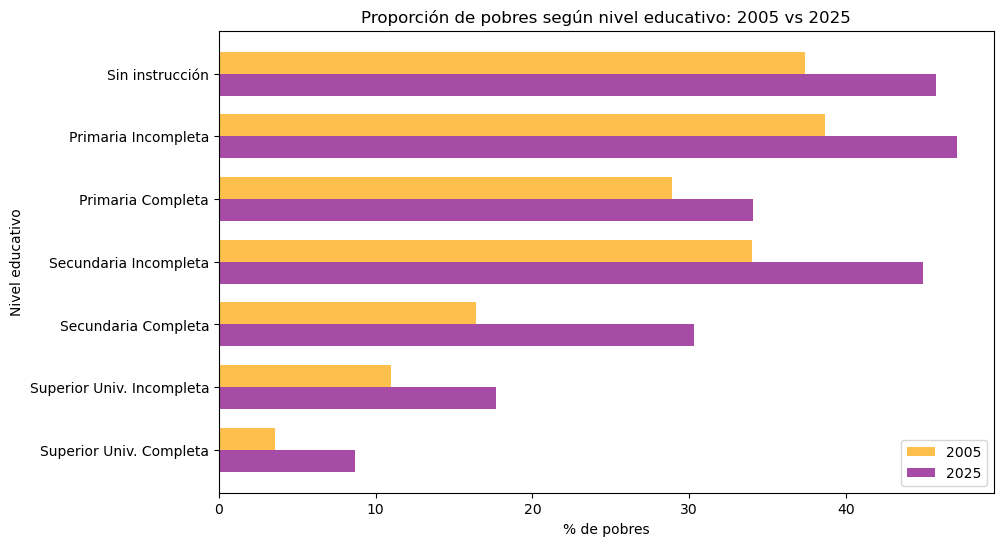

se ve cómo al aumentar el nivel educativo, disminuye la proporción de pobres en cada año


In [55]:
#GRÁFICO DE BARRAS POBRE Y NIVEL_ED

# Mapear NIVEL_ED a nombres descriptivos
niveles_map = {
    1: "Primaria Incompleta",
    2: "Primaria Completa",
    3: "Secundaria Incompleta",
    4: "Secundaria Completa",
    5: "Superior Univ. Incompleta",
    6: "Superior Univ. Completa",
    7: "Sin instrucción"
}
respondieron["NIVEL_ED_LABEL"] = respondieron["NIVEL_ED"].map(niveles_map)

# Calcular % de pobres por nivel educativo y año, evitando FutureWarning
tabla_por_anyo = (respondieron.groupby(["YEAR","NIVEL_ED_LABEL"], observed=False)
                  ["pobre"].mean().reset_index())
tabla_por_anyo["porcentaje_pobres"] = (tabla_por_anyo["pobre"]*100).round(2)

# Mantener el orden lógico de niveles educativos
orden = ["Sin instrucción", "Primaria Incompleta", "Primaria Completa",
         "Secundaria Incompleta", "Secundaria Completa",
         "Superior Univ. Incompleta", "Superior Univ. Completa"]

# Extraer valores para cada año
val_2005 = tabla_por_anyo[tabla_por_anyo["YEAR"]==2005].set_index("NIVEL_ED_LABEL").reindex(orden)["porcentaje_pobres"]
val_2025 = tabla_por_anyo[tabla_por_anyo["YEAR"]==2025].set_index("NIVEL_ED_LABEL").reindex(orden)["porcentaje_pobres"]

# Configurar posiciones de barras
y = np.arange(len(orden))
ancho = 0.35

# Graficar (barras horizontales)
plt.figure(figsize=(10,6))
plt.barh(y - ancho/2, val_2005, height=ancho, label="2005", color="orange", alpha=0.7)
plt.barh(y + ancho/2, val_2025, height=ancho, label="2025", color="purple", alpha=0.7)

plt.yticks(y, orden)
plt.xlabel("% de pobres")
plt.ylabel("Nivel educativo")
plt.title("Proporción de pobres según nivel educativo: 2005 vs 2025")
plt.legend()
plt.gca().invert_yaxis()  # opcional: para que 'Sin instrucción' quede arriba

plt.savefig(f"{CARPETA_FIG}/barrasNIVEL_ED.png", dpi=150, bbox_inches="tight")
plt.show()

print("se ve cómo al aumentar el nivel educativo, disminuye la proporción de pobres en cada año")


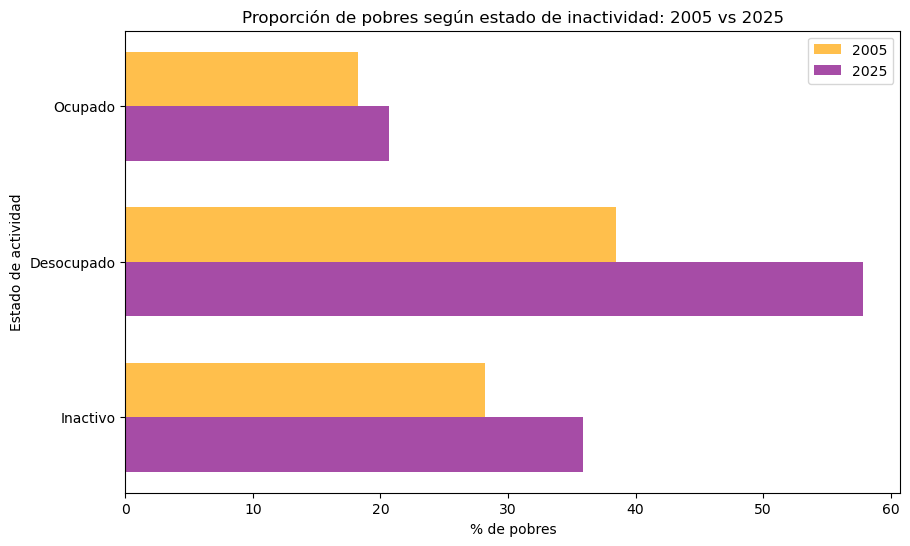

In [56]:
#GRÁFICO DE BARRAS POBRE Y ESTADO DE INACTIVIDAD

# Mapear ESTADO a nombres descriptivos
estado_map = {
    1: "Ocupado",
    2: "Desocupado",
    3: "Inactivo"
}
#saqué los de Menor de 10 años y Ns/Nr

respondieron["ESTADO_LABEL"] = respondieron["ESTADO"].map(estado_map)

# Calcular % de pobres por ESTADO y año, evito FutureWarning con  observed=False
tabla_estado = (respondieron.groupby(["YEAR","ESTADO_LABEL"], observed=False)
                ["pobre"].mean().reset_index())
tabla_estado["porcentaje_pobres"] = (tabla_estado["pobre"]*100).round(2)

# Fijo un orden lógico de estados
orden_estado = ["Ocupado","Desocupado","Inactivo"]

# Extraer valores para cada año
val_2005 = tabla_estado[tabla_estado["YEAR"]==2005].set_index("ESTADO_LABEL").reindex(orden_estado)["porcentaje_pobres"]
val_2025 = tabla_estado[tabla_estado["YEAR"]==2025].set_index("ESTADO_LABEL").reindex(orden_estado)["porcentaje_pobres"]

# Configurar posiciones de barras
y = np.arange(len(orden_estado))
ancho = 0.35

# Graficar (barras horizontales)
plt.figure(figsize=(10,6))
plt.barh(y - ancho/2, val_2005, height=ancho, label="2005", color="orange", alpha=0.7)
plt.barh(y + ancho/2, val_2025, height=ancho, label="2025", color="purple", alpha=0.7)

plt.yticks(y, orden_estado)
plt.xlabel("% de pobres")
plt.ylabel("Condición de actividad")
plt.title("Proporción de pobres según estado de inactividad: 2005 vs 2025")
plt.legend()
plt.gca().invert_yaxis()  # opcional: para que 'Ocupado' quede arriba

plt.savefig(f"{CARPETA_FIG}/barrasESTADO.png", dpi=150, bbox_inches="tight")
plt.show()

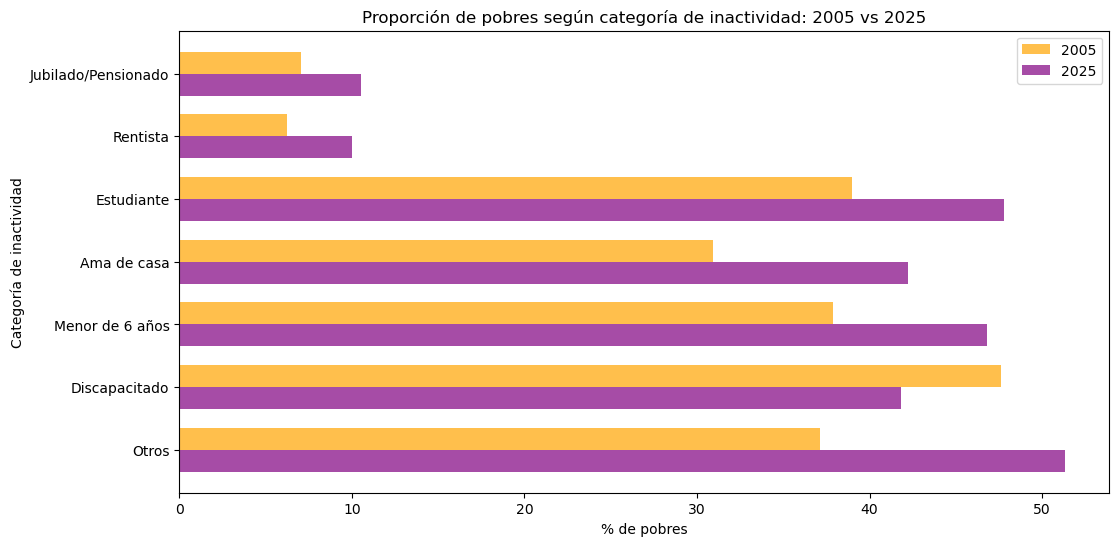

In [53]:
# GRÁFICO DE BARRAS HORIZONTALES POBRE Y CATEGORÍA DE INACTIVIDAD

# Mapear CAT_INAC a nombres descriptivos
cat_inac_map = {
    1: "Jubilado/Pensionado",
    2: "Rentista",
    3: "Estudiante",
    4: "Ama de casa",
    5: "Menor de 6 años",
    6: "Discapacitado",
    7: "Otros"
}
respondieron["CAT_INAC_LABEL"] = respondieron["CAT_INAC"].map(cat_inac_map)

# Calcular % de pobres por CAT_INAC y año
tabla_cat = (respondieron.groupby(["YEAR","CAT_INAC_LABEL"], observed=False)
             ["pobre"].mean().reset_index())
tabla_cat["porcentaje_pobres"] = (tabla_cat["pobre"]*100).round(2)

# Mantener un orden lógico de categorías
orden_cat = ["Jubilado/Pensionado", "Rentista", "Estudiante", 
             "Ama de casa", "Menor de 6 años", "Discapacitado", "Otros"]

# Extraer valores para cada año
val_2005 = tabla_cat[tabla_cat["YEAR"]==2005].set_index("CAT_INAC_LABEL").reindex(orden_cat)["porcentaje_pobres"]
val_2025 = tabla_cat[tabla_cat["YEAR"]==2025].set_index("CAT_INAC_LABEL").reindex(orden_cat)["porcentaje_pobres"]

# Configurar posiciones de barras
y = np.arange(len(orden_cat))
ancho = 0.35

# Graficar barras horizontales
plt.figure(figsize=(12,6))
plt.barh(y - ancho/2, val_2005, height=ancho, label="2005", color="orange", alpha=0.7)
plt.barh(y + ancho/2, val_2025, height=ancho, label="2025", color="purple", alpha=0.7)

# Etiquetas
plt.yticks(y, orden_cat)
plt.xlabel("% de pobres")
plt.ylabel("Categoría de inactividad")
plt.title("Proporción de pobres según categoría de inactividad: 2005 vs 2025")
plt.legend()
plt.gca().invert_yaxis()  # Para que la primera categoría aparezca arriba

# Guardar y mostrar
plt.savefig(f"{CARPETA_FIG}/barrasINAC_horizontal.png", dpi=150, bbox_inches="tight")
plt.show()